### Define your global model context
So you don't need to specify -m in each individual cell. It will default to the model you define.

In [5]:
%%ml model -n census

Also note, compared to Train-local notebook, the big difference is the existance of "--cloud" in most cells.

### Define Training Dataset
Training needs preprocessed data that are created in previous preprocess notebook.

First let's define the Cloud Storage path of the training data. Assuming those data has been generated in preprocess notebook.

In [1]:
# Some code to determine a unique bucket name for the purposes of the sample
from gcp.context import Context

project = Context.default().project_id
ml_bucket_name = project + '-mldata'
ml_bucket_path = 'gs://' + ml_bucket_name

train_data_path = ml_bucket_path + '/sampledata/ml/census/preprocessed_train*'
test_data_path = ml_bucket_path + '/sampledata/ml/census/preprocessed_test*'
output_path = ml_bucket_path + '/sampledata/ml/census/'
metadata_path = ml_bucket_path + '/sampledata/ml/census/metadata.yaml'

Define dataset:

In [2]:
%%ml dataset --name census_data
train: $train_data_path
test: $test_data_path
metadata: $metadata_path

### Define TensorFlow graph

In [3]:
%%tensorflow graph


import google.cloud.ml as cloudml
import google.cloud.ml.models as models
import json
import math
import tensorflow as tf
from tensorflow.python.ops import sparse_ops as sparse_ops


class CensusModel(models.Classification):
  def __init__(self):
    super(CensusModel, self).__init__()
    
  def create_graph(self):
    with tf.Graph().as_default() as g:
      attrs, text = self._create_inputs()
      hidden_layer = self._create_hidden_layer(attrs, text['ids'], text['values'])
      logits = self._create_logits_layer(hidden_layer)
      self._create_outputs(logits)
      self._create_training(logits)
      self._create_initialization()
    return g
  
  def _create_inputs(self):
    with tf.name_scope('inputs'):
      self.examples = tf.placeholder(tf.string, name = 'examples')
      parsed_examples = self.parse_features(self.examples)
      self.targets = parsed_examples['target']
      # Our input data doesn't have Ids.
      # Assign empty strings to the ids tensor, in the same shape as the targets.
      self.keys = tf.fill(tf.shape(self.targets), tf.constant('', dtype=tf.string), name='keys')
      return parsed_examples['attrs'], parsed_examples['native_country']
    
  def _create_hidden_layer(self, attrs, ids, values):
    attrs_size = self.metadata.features['attrs']['size']
    text_size = self.metadata.features['native_country']['size']
    output_size = self.hyperparams.hidden_layer_size
    
    with tf.name_scope('hidden_layer'):
      initial_weights = tf.truncated_normal([ attrs_size, output_size ],
                                            stddev = 1.0 / math.sqrt(attrs_size))
      weights = tf.Variable(initial_weights, name = 'weights')
      initial_biases = tf.zeros([ output_size ])
      biases = tf.Variable(initial_biases, name = 'biases')
      xw = tf.matmul(attrs, weights)
      xwb = tf.nn.bias_add(xw, biases)

      """   Enable the following when service TF supports sparse_tensor_dense_matmul
      initial_weights_text = tf.truncated_normal([text_size, output_size],
                                                 stddev=1.0 / math.sqrt(text_size))
      weights_text = tf.Variable(initial_weights_text, name='weights_text')
      initial_biases_text = tf.zeros([output_size])
      biases_text = tf.Variable(initial_biases_text, name='biases_text')
      sparse_text = sparse_ops.sparse_merge(ids, values, text_size, 'sparse_merge')
      xw_text = sparse_ops.sparse_tensor_dense_matmul(sparse_text, weights_text, name='text_embedding_lookup')
      xwb_text = tf.nn.bias_add(xw_text, biases_text)
      xwb_combined = xwb_text + xwb
      """
      return tf.nn.relu(xwb)
    
  def _create_logits_layer(self, hidden_layer):
    input_size = self.hyperparams.hidden_layer_size
    output_size = self.metadata.labels
    with tf.name_scope('logits_layer'):
      initial_weights = tf.truncated_normal([input_size, output_size],
                                            stddev=1.0 / math.sqrt(input_size))
      weights = tf.Variable(initial_weights, name='weights')
      initial_biases = tf.zeros([output_size])
      biases = tf.Variable(initial_biases, name='biases')
      return tf.nn.bias_add(tf.matmul(hidden_layer, weights), biases)
    
  def _create_outputs(self, logits):
    with tf.name_scope('outputs'):
      self.scores = tf.nn.softmax(logits, name='scores')
      # The tensor in self.predictions will be compared to self.targets
      # by the cloud service during evaluation.
      self.predictions = tf.arg_max(logits, 1, name='prediction')
      
  def _create_training(self, logits):
    with tf.name_scope('train'):
      with tf.name_scope('target'):
        tensor = tf.convert_to_tensor(self.targets)
        batch_size = tf.shape(tensor)[0]
        hot_rows = tf.cast(tf.expand_dims(
            tf.range(0, batch_size), 1), tensor.dtype)
        hot_indices = tf.concat(concat_dim = 1, values = [ hot_rows, tensor ])
        shape = tf.cast(tf.pack([batch_size, self.metadata.labels]), tensor.dtype)
        encoded_targets = tf.sparse_to_dense(
            hot_indices,
            shape,
            sparse_values = tf.constant(1, dtype = tf.float32),
            default_value = tf.constant(0, dtype = tf.float32))
      entropy = tf.nn.softmax_cross_entropy_with_logits(logits,
                                                        encoded_targets)
      self.loss = tf.reduce_mean(entropy, name = 'loss')
      self.global_step = tf.Variable(0, name='global_step', trainable=False)
      optimizer = tf.train.AdagradOptimizer(self.hyperparams.learning_rate)
      self.train = optimizer.minimize(self.loss, self.global_step)
      
  def _create_initialization(self):
    self.initialize = tf.initialize_all_variables()

If you want to see the visualized graph:

In [ ]:
%%ml train -v v1 -d census_data -o $output_path --visualize
batch_size: 64
learning_rate: 0.1
hidden_layer_size: 100
steps: 4000

### Training

In [7]:
%%ml train -v v1 -d census_data -o $output_path --cloud --overwrite
batch_size: 64
learning_rate: 0.1
hidden_layer_size: 100
steps: 3000

Watch live training events (loss, error)

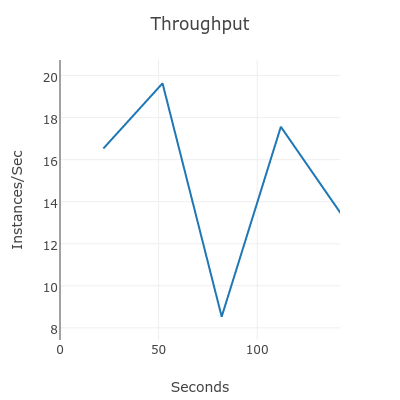

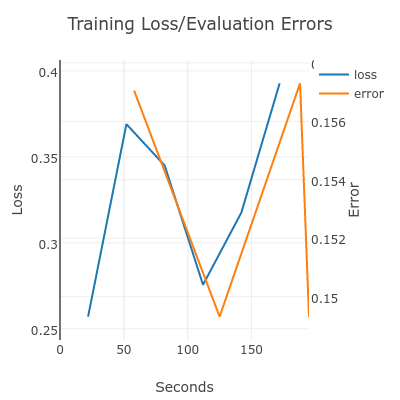

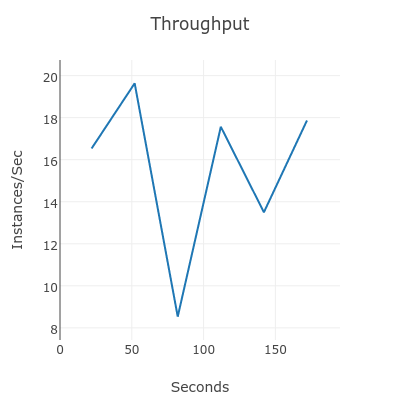

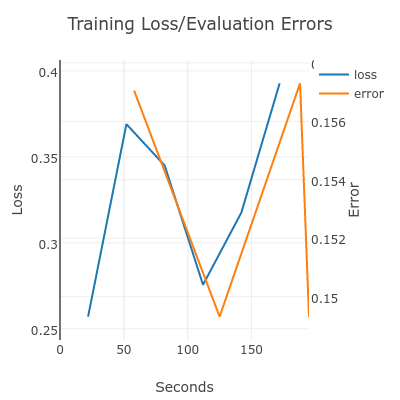

In [8]:
%%ml analyze -v v1 --cloud

Let's train another version with smaller learning_rate.

In [9]:
%%ml train -v v2 -d census_data -o $output_path --cloud --overwrite
batch_size: 64
learning_rate: 0.01
hidden_layer_size: 100
steps: 3000

Now you can compare 2 models.

Running Dataflow analyzer job
Dataflow analyzer job complete


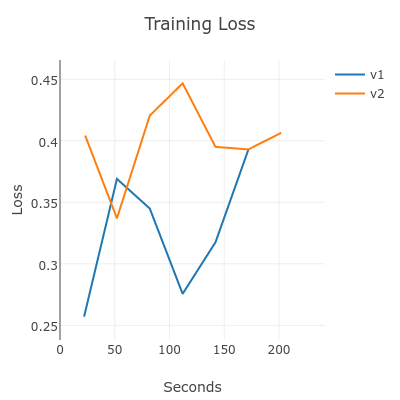

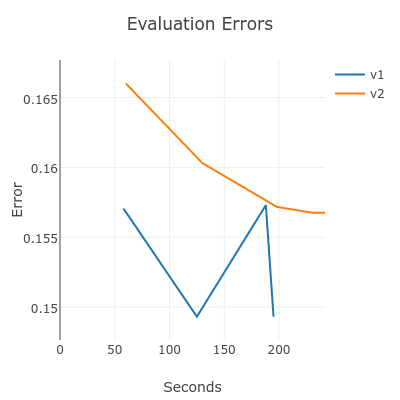

In [12]:
%%ml analyze -v v1 v2 --cloud

### Describe your trained models.
You can use --model to override default, but if not specified, it will take the default model specified in the first cell.

In [10]:
%%ml describe --cloud